In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
data_path = "../data"
file = "train"

df = pd.read_csv("{}/{}_final.csv".format(data_path, file))
label = pd.read_csv("{}/label_final.csv".format(data_path), 
                    header=None, names=["SalePrice_log"])
df.head()

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,TotalSF,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.320894,-0.267660,3,3,3,2,7,5,0.652174,0.243243,1.034410,3,2,4,3,1,6,0.092710,1,0.0,-0.898157,-0.300181,4,4,-0.524119,1.024186,0.0,0.342891,1.0,0.000000,0.0,1.0,0.0,0.0,3,1.0,7,-1.0,0,0.589744,2,0.0,0.281573,3,

In [3]:
seed = 88

linear_models = {
    'linear': LinearRegression(n_jobs = -1),
    'lasso': Lasso(random_state = seed),
    'ridge': Ridge(random_state = seed),
    'kr': KernelRidge(),
    'elnt': ElasticNet(random_state = seed),
    'dt': DecisionTreeRegressor(random_state = seed),
    'svm': SVR(),
    'knn': KNeighborsRegressor(n_jobs = -1),
    'rf':  RandomForestRegressor(n_jobs = -1, random_state = seed),
    'et': ExtraTreesRegressor(n_jobs = -1, random_state = seed),
    'ab': AdaBoostRegressor(random_state = seed),
    'gb': GradientBoostingRegressor(random_state = seed),
    'xgb': XGBRegressor(random_state = seed, n_jobs = -1)
#     'lgb': LGBMRegressor(random_state = seed, n_jobs = -1)
}

### Model Training

We first train with a single train-test split and then do a k=10 CV.

In [4]:
label.head()

,SalePrice_log
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216


In [5]:
seed = 888
X = df
y = label

# def train_model_r_sq(model, X, y):
#     X_train, X_test, y_train, y_test = train_test_split(
#                                             X, y, test_size=0.3,
#                                             random_state=seed
#                                         )
#     model.fit(X_train, y_train)
#     return 

def train_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
                                            X, y, test_size=0.3,
                                            random_state=seed
                                        )
    model.fit(X_train, y_train)
    return np.sqrt(mean_squared_error(model.predict(X_test), y_test)), model.score(X_train, y_train)

def display_single_split_results(model_group, X, y):
    dp = 3
    results = []
    for name, model in model_group.items():
        rmse, r_sq = train_model(model, X, y)
        results.append(
            (name, round(rmse, dp), round(r_sq*100, dp))
        )
    
    # Unzip and then tranpose to create the columns. 
    tuple_arr = [list(x) for x in zip(*results)]
    return pd.DataFrame(np.transpose(tuple_arr), columns=["model", "rmse", "r_sq"])

def cross_validate_model(model, X, y, cv):
    dp=3
    neg_mse = cross_val_score(model, X, y, 
                                      cv=cv, n_jobs=-1, 
                                      scoring = 'neg_mean_squared_error'
                                     )
    x_val_score = np.round(np.sqrt(-1*neg_mse), dp)
    return x_val_score.mean()

def display_cv_results(model_group, X, y, cv):
    dp = 3
    results = []
    for name, model in model_group.items():
        cv_rmse = cross_validate_model(model, X, y, cv)
        results.append(
            (name, round(cv_rmse, dp))
        )
    
    # Unzip and then tranpose to create the columns. 
    tuple_arr = [list(x) for x in zip(*results)]
    return pd.DataFrame(np.transpose(tuple_arr), columns=["model", "cv_rmse"]) 

In [6]:
results_df = display_single_split_results(linear_models, X, y)
results_df.sort_values("rmse")

[22:59:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model,rmse,r_sq
6,svm,0.143,94.402
12,xgb,0.149,96.069
2,ridge,0.151,94.776
11,gb,0.151,97.054
9,et,0.165,100.0
8,rf,0.167,97.543
10,ab,0.176,86.803
7,knn,0.194,86.945
5,dt,0.226,100.0
3,kr,0.25,94.404


In [7]:
results_df["rmse"] = results_df["rmse"].astype(float)
results_df["r_sq"] = results_df["r_sq"].astype(float)

In [8]:
results_df[~results_df["model"].isin(["linear"])]["model"]

1     lasso
2     ridge
3        kr
4      elnt
5        dt
6       svm
7       knn
8        rf
9        et
10       ab
11       gb
12      xgb
Name: model, dtype: object

For more aesthetic configurations check it out [here](https://seaborn.pydata.org/tutorial/aesthetics.html)

In [10]:
results_cv = display_cv_results(linear_models, X, y, cv=10)
results_cv["cv_rmse"] = results_cv["cv_rmse"].astype(float)
results_cv

,model,cv_rmse
0,linear,7602509716.001
1,lasso,0.399
2,ridge,0.126
3,kr,0.162
4,elnt,0.399
5,dt,0.197
6,svm,0.123
7,knn,0.181
8,rf,0.149
9,et,0.148


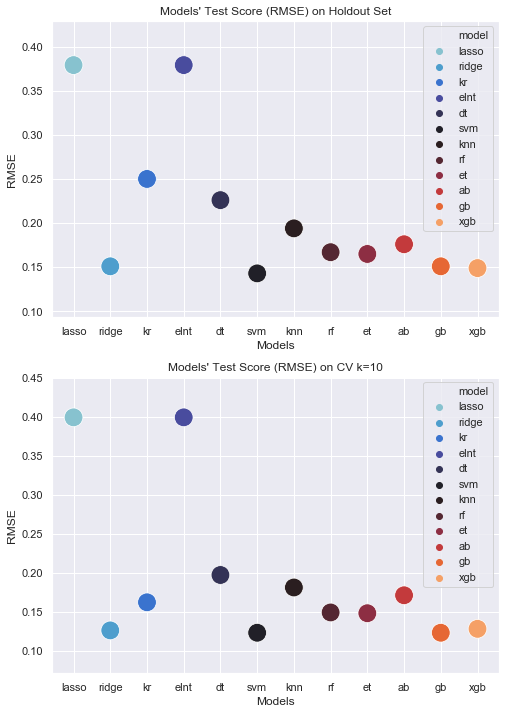

In [24]:
num_cols = 1

fig, axes = plt.subplots(2, num_cols)
fig.set_figheight(12)
fig.set_figwidth(8)
fig.subplots_adjust(hspace=0.2, wspace=0.5)

sns.set()
# sns.set_style("ticks")
# sns.axes_style("darkgrid")

title = "Models' Test Score (RMSE) on Holdout Set"
models_except_ols = results_df[~results_df["model"].isin(["linear"])]["model"]
sns.scatterplot(models_except_ols, 
                results_df["rmse"], palette='icefire', 
                hue=models_except_ols, s=350, 
                ax=axes[0]).set(
    xlabel="Models",
    ylabel="RMSE",
    title=title
)
# plt.xticks(rotation=90)
# plt.legend(loc=(1.02, 0.03))

title = "Models' Test Score (RMSE) on CV k=10"
models_except_ols = results_cv[~results_cv["model"].isin(["linear"])]["model"]
sns.scatterplot(models_except_ols, 
                results_cv["cv_rmse"], palette='icefire', 
                hue=models_except_ols, s=350,
                ax=axes[1]).set(
    xlabel="Models",
    ylabel="RMSE",
    title=title
)
# plt.xticks(rotation=90)
# plt.legend(loc=(1.02, 0.03))

plt.show()

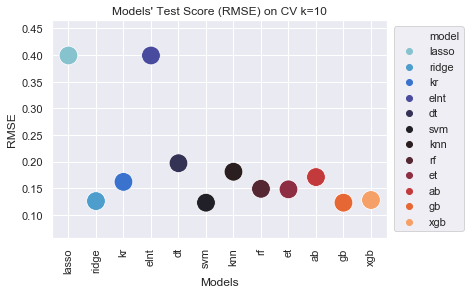

In [13]:
sns.set()
# sns.set_style("ticks")
# sns.axes_style("darkgrid")

title = "Models' Test Score (RMSE) on CV k=10"
models_except_ols = results_cv[~results_cv["model"].isin(["linear"])]["model"]
sns.scatterplot(models_except_ols, 
                results_cv["cv_rmse"], palette='icefire', 
                hue=models_except_ols, s=350).set(
    xlabel="Models",
    ylabel="RMSE",
    title=title
)
plt.xticks(rotation=90)
plt.legend(loc=(1.02, 0.03))
plt.show()

### Optimising Hyperparameters